In [1]:
import torch
import argparse
import numpy as np
import random
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
from backdoor import *

In [19]:
size = 0
label = np.array([1,1,3])
p_label = 5
target_indices = np.arange(len(label))[label == p_label]
size = len(target_indices)
percent = 1

p_indices = np.random.uniform(size = size) >= (1 - percent)
# print(size,p_indices)
if len(p_indices) == 0:
    p_indices = []
    c_indices = np.arange(len(label))
else:
    mask=np.full(size,True,dtype=bool)
    mask[p_indices] = False
    p_indices = target_indices[p_indices]

    mask=np.full(len(label),True,dtype=bool)
    mask[p_indices] = False
    c_indices = np.arange(len(label))[mask]


In [20]:
target_indices, p_indices,c_indices

(array([], dtype=int64), [], array([0, 1, 2]))

In [ ]:

trigger = torch.load('trigger.pt',map_location=torch.device('cpu'))

/tmp/ipykernel_4030195/3287214458.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trigger = torch.load('trigger.pt',map_location=torch.device('cpu'))


In [3]:
from datasets import build_continual_dataloader
from configs.cifar100_l2p import get_args_parser

In [ ]:
import sys

sys.argv ="""/home/woody/iwi1/iwi1102h/software/private/conda/envs/l2p/bin/python -m torch.distributed.launch \
        --nproc_per_node=1 \
        --use_env main.py \
        cifar100_l2p \
        --model vit_base_patch16_224 \
        --batch-size 16 \
        --data-path ./local_datasets/ \
        --output_dir ./output \
        --use_trigger false \
        --poison_rate 0.1 """.split('\n')

parser = argparse.ArgumentParser('L2P training and evaluation configs')
# config = parser.parse_known_args()[-1][0]

subparser = parser.add_subparsers(dest='subparser_name')


config_parser = subparser.add_parser('cifar100_l2p', help='Split-CIFAR100 L2P configs')


seed = 1

get_args_parser(config_parser)

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

cudnn.benchmark = True
# args = argparse.Namespace(verbose=False, verbose_1=False)
args = config_parser.parse_args()

import utils
utils.init_distributed_mode(args)

Not using distributed mode


In [5]:
data_loader, class_mask = build_continual_dataloader(args)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
y = None
for x in data_loader[0]['train']:
    y = x
    break

In [33]:
y[0][0].shape

torch.Size([3, 224, 224])

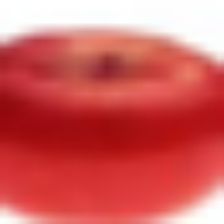

In [7]:
TF.to_pil_image(y[0][0])

In [61]:
checker_patch = torch.FloatTensor([[[1,0,1],[0,1,0],[1,0,1]]])
checker_patch = checker_patch.repeat(3,10,10)
TF.to_pil_image(checker_patch)

In [ ]:
Y

In [64]:
checker_patch.shape

torch.Size([3, 30, 30])

In [65]:
checker_patch.shape

torch.Size([3, 30, 30])

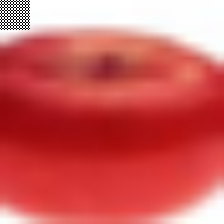

In [67]:
y_ = torch.clamp(apply_noise_patch(checker_patch.unsqueeze(0),y[0][0].clone()),0,1)
TF.to_pil_image(y_)

In [22]:
# assuming your image in x
h_img = TF.to_pil_image(trigger[0])

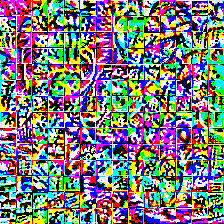

In [23]:
h_img

In [24]:
h_img.save('heat.png')